# 01 - NMF experiments on Zeisel

* nimfa installed with `pip`
* https://stackoverflow.com/questions/46516022/reconstruction-error-on-test-set-for-nmf-aka-nnmf-in-scikit-learn
    * use the `beta_divergence` function

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from copy import deepcopy
from numpy import ma
from sklearn.decomposition import NMF, PCA
from sklearn.manifold import TSNE
from umap import UMAP

import nimfa as ni

In [2]:
zeisel_path = '/media/tmo/data/work/datasets/zeisel/expression_sara_filtered.txt'
zeisel_meta_path = '/media/tmo/data/work/datasets/zeisel/expression_mRNA_17-Aug-2014.txt'

In [3]:
%%time
zeisel_df = pd.read_csv(zeisel_path, sep='\t', skiprows=1, header=None, index_col=0)
zeisel_df.index.name = 'gene'

CPU times: user 4.63 s, sys: 386 ms, total: 5.02 s
Wall time: 5.01 s


In [4]:
zeisel_meta_df = pd.read_table(zeisel_meta_path, nrows=12, index_col=1, header=None)
zeisel_meta_df.drop(zeisel_meta_df.columns[0], axis=1, inplace=True)
zeisel_meta_df = zeisel_meta_df.T.reset_index()[['tissue', 'level1class', 'level2class']]
zeisel_meta_df.index.name = 'cell'

In [5]:
for meta_col in zeisel_meta_df.columns:
    zeisel_meta_df[meta_col] = zeisel_meta_df[meta_col].astype('category')

In [6]:
zeisel_meta_df.head()

1,tissue,level1class,level2class
cell,,,
0,sscortex,interneurons,Int10
1,sscortex,interneurons,Int10
2,sscortex,interneurons,Int6
3,sscortex,interneurons,Int10
4,sscortex,interneurons,Int9


In [7]:
genes = zeisel_df.index

In [8]:
zeisel_m = zeisel_df.as_matrix()

In [9]:
zeisel_m.shape

(13063, 3005)

# Model fitting

In [10]:
def fit_nmf(X, model = NMF(n_components=20,                            
                           init='nndsvd', 
                           random_state=42, 
                           verbose=False)):
    fit_model = deepcopy(model)
    
    W = fit_model.fit_transform(X) # basis matrix
    H = fit_model.components_      # mixture matrix
       
    return fit_model, W, H

In [11]:
def tsne_embed(X):
    return pd.DataFrame(TSNE().fit_transform(X))

# Prep

In [57]:
from sklearn.preprocessing import StandardScaler

In [82]:
scaler = StandardScaler(with_mean=False)

In [83]:
scaled = scaler.fit_transform(zeisel_m.T).T

/home/tmo/work/batiskav/installs/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [84]:
scaled.shape

(13063, 3005)

# PCA

In [107]:
pca = PCA(n_components=12)
pca

PCA(copy=True, iterated_power='auto', n_components=12, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [101]:
%%time
pca.fit(scaled.T)

CPU times: user 13.6 s, sys: 31 s, total: 44.7 s
Wall time: 4.05 s


PCA(copy=True, iterated_power='auto', n_components=12, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)

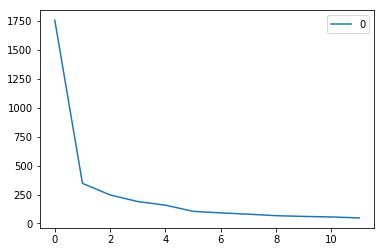

In [102]:
pd.DataFrame(pca.explained_variance_).plot()
plt.show()

In [103]:
X_pca = pca.transform(scaled.T)

In [106]:
X_pca.shape

(3005, 12)

In [ ]:
%%time
pca_12_tsne_df = tsne_embed(X_pca)

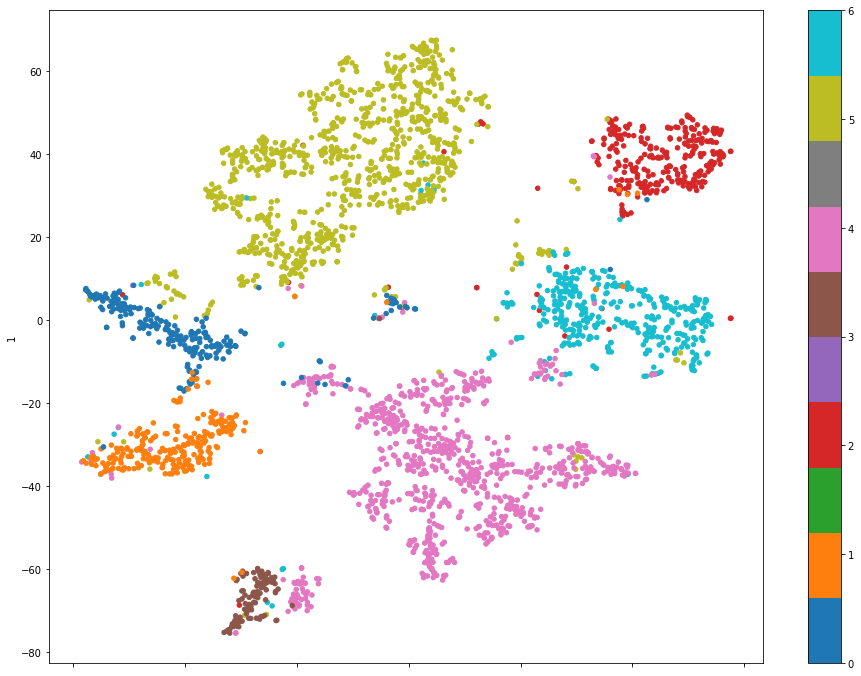

In [133]:
pca_12_tsne_df.plot.scatter(x=0, y=1, c=zeisel_meta_df['level1class'].cat.codes, cmap=plt.cm.get_cmap('tab10'), figsize=(16,12))
plt.show()

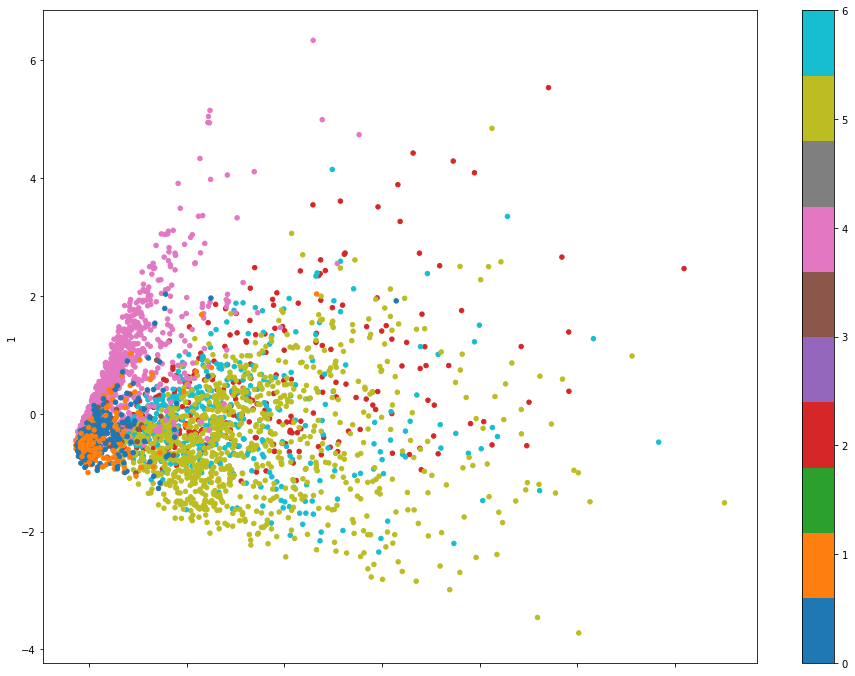

In [114]:
pd.DataFrame(X_pca[:, [0, 1]]).plot.scatter(x=0, y=1, c=zeisel_meta_df['level1class'].cat.codes, cmap=plt.cm.get_cmap('tab10'), figsize=(16,12))
plt.show()

# NMF on scaled

* reconstruction error smaller --> reason?
* apparently better results in the t-SNE

In [86]:
model_scaled_20, W_scaled_20, H_scaled_20 = fit_nmf(scaled)

In [87]:
model_scaled_20.reconstruction_err_

5382.9081032526301

/home/tmo/work/batiskav/installs/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


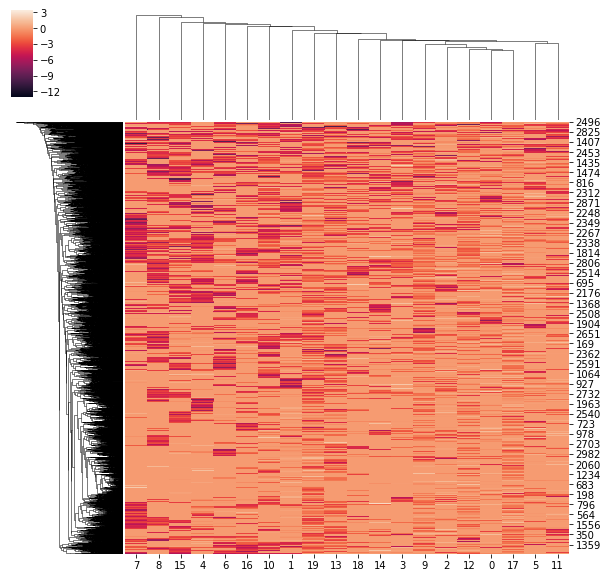

In [88]:
sns.clustermap(ma.filled(np.log(ma.masked_equal(H_scaled_20, 0)).T, 0))
plt.show()

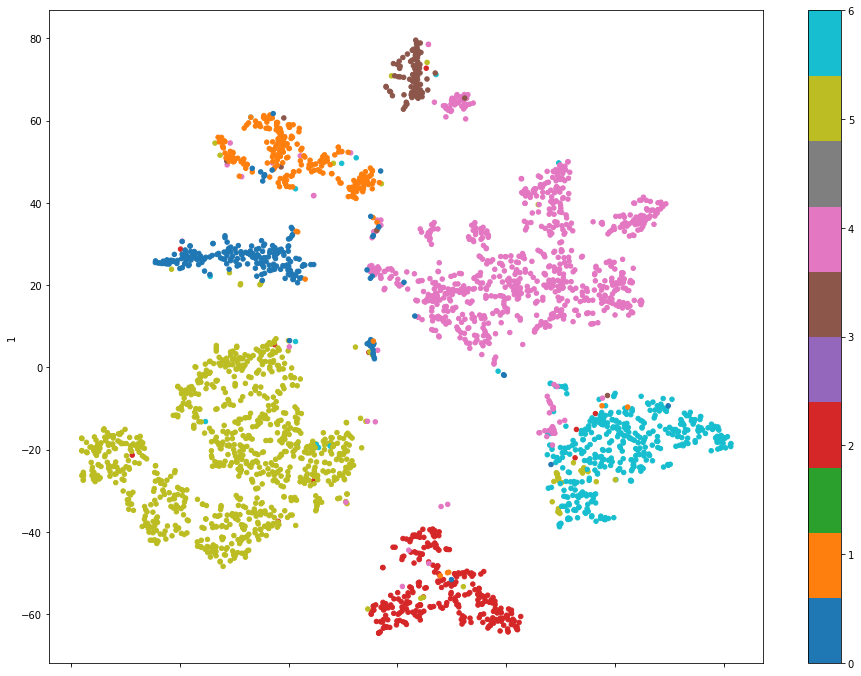

CPU times: user 1min 1s, sys: 14.9 s, total: 1min 16s
Wall time: 1min 15s


In [118]:
%%time
scaled_20_tsne_df = tsne_embed(H_scaled_20.T)
scaled_20_tsne_df.plot.scatter(x=0, y=1, c=zeisel_meta_df['level1class'].cat.codes, cmap=plt.cm.get_cmap('tab10'), figsize=(16,12))
plt.show()

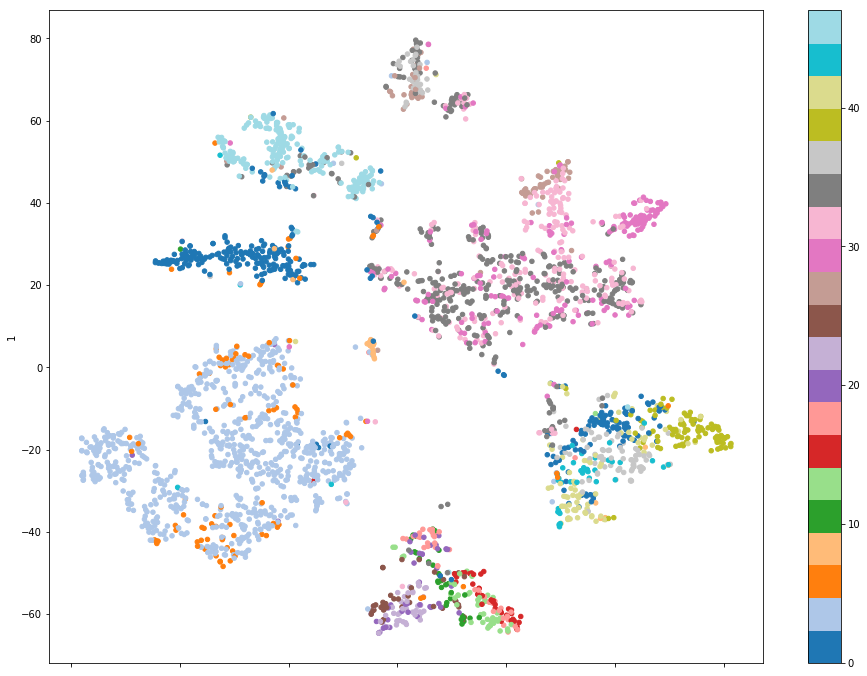

In [119]:
scaled_20_tsne_df.plot.scatter(x=0, y=1, c=zeisel_meta_df['level2class'].cat.codes, cmap=plt.cm.get_cmap('tab20'), figsize=(16,12))
plt.show()

# 20 components

In [125]:
%%time
model, W, H = fit_nmf(zeisel_m)

CPU times: user 1min 30s, sys: 44.6 s, total: 2min 15s
Wall time: 1min 15s


In [126]:
model.reconstruction_err_

11380.607178310001

/home/tmo/work/batiskav/installs/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


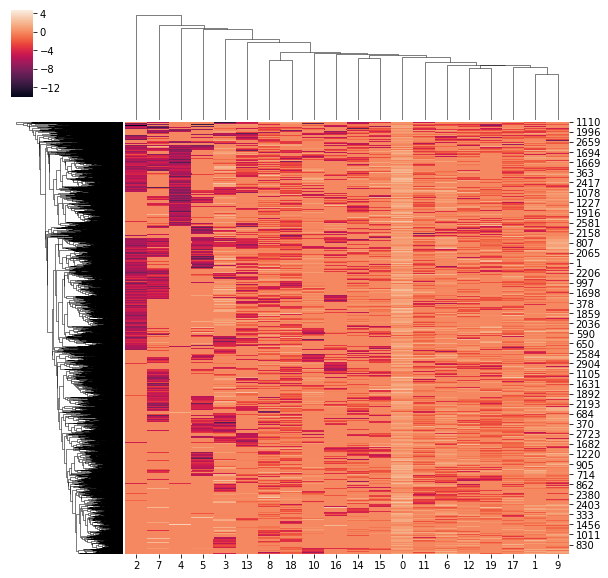

In [136]:
sns.clustermap(ma.filled(np.log(ma.masked_equal(H, 0)).T, 0))
plt.show()

In [134]:
%%time
tsne_df = pd.DataFrame(TSNE(random_state=666).fit_transform(H.T))

CPU times: user 1min 3s, sys: 15.3 s, total: 1min 18s
Wall time: 1min 18s


In [35]:
%%time
umap_df = pd.DataFrame(UMAP(random_state=666).fit_transform(H.T))

NameError: name 'H' is not defined

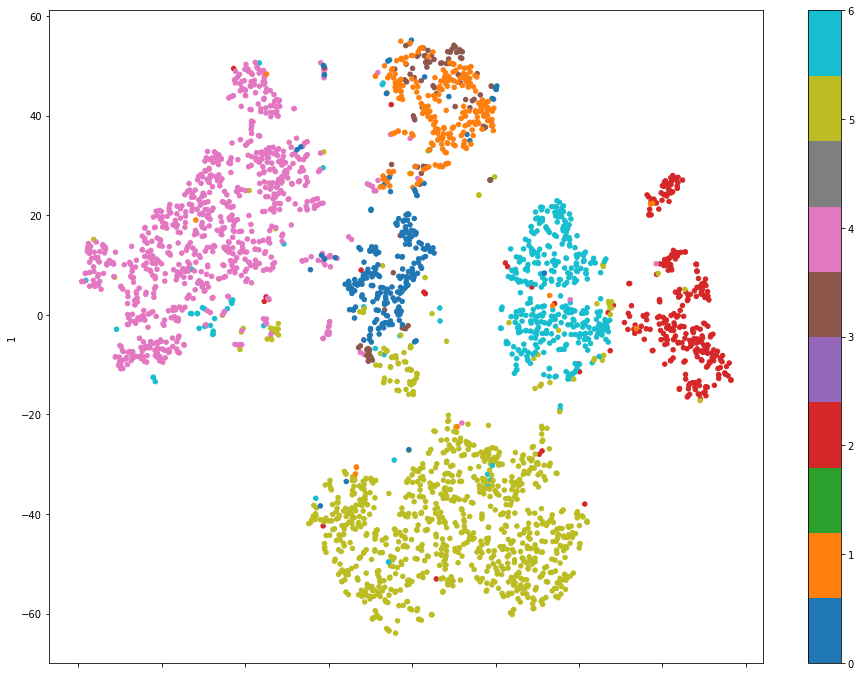

In [135]:
tsne_df.plot.scatter(x=0, y=1, c=zeisel_meta_df['level1class'].cat.codes, cmap=plt.cm.get_cmap('tab10'), figsize=(16,12))
plt.show()

In [72]:
%%time
model2 = NMF(n_components=20,
             alpha=10,
             init='nndsvd', 
             random_state=42, 
             verbose=False)

model2, W2, H2 = fit_nmf(zeisel_m, model2)

CPU times: user 1min 31s, sys: 44.7 s, total: 2min 15s
Wall time: 1min 16s


In [73]:
model2.reconstruction_err_

11380.50608330567

/home/tmo/work/batiskav/installs/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


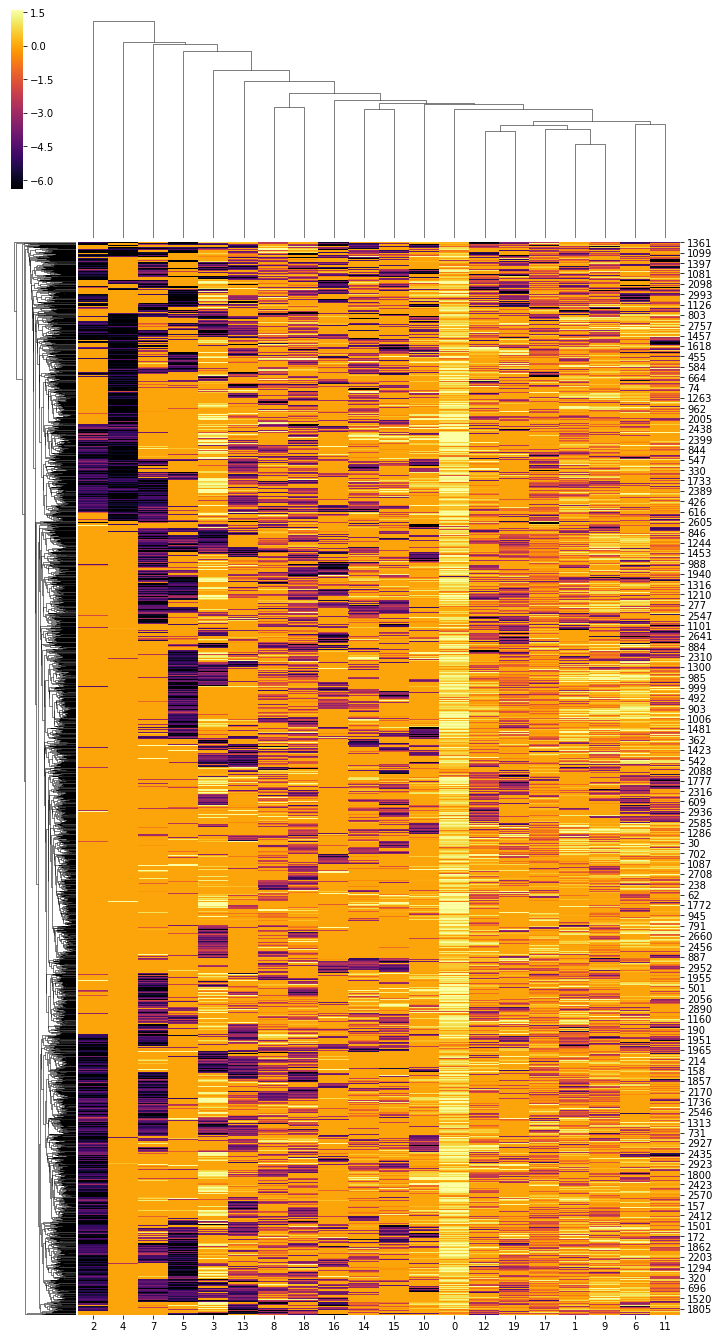

In [74]:
sns.clustermap(ma.filled(np.log(ma.masked_equal(H2, 0)).T, 0),
               cmap='inferno',
               robust=True,
               figsize=(12, 24))
plt.show()

In [20]:
%%time
tsne_df_2 = pd.DataFrame(TSNE(random_state=666).fit_transform(H2.T))

CPU times: user 1min 3s, sys: 15 s, total: 1min 18s
Wall time: 1min 18s


In [54]:
%%time
umap_df_l2 = pd.DataFrame(UMAP(random_state=666, metric='l2').fit_transform(H2.T))

CPU times: user 14.8 s, sys: 10.4 s, total: 25.2 s
Wall time: 12.2 s


In [55]:
%%time
umap_df_l1 = pd.DataFrame(UMAP(random_state=666, metric='l1').fit_transform(H2.T))

CPU times: user 14.2 s, sys: 8.06 s, total: 22.3 s
Wall time: 12.4 s


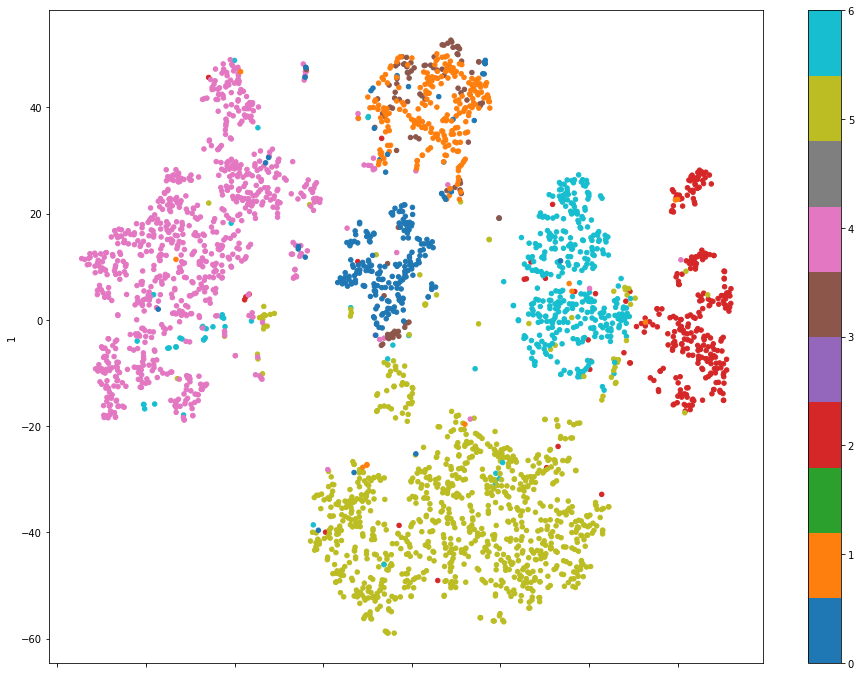

In [52]:
tsne_df_2.plot.scatter(x=0, y=1, c=zeisel_meta_df['level1class'].cat.codes, cmap=plt.cm.get_cmap('tab10'), figsize=(16,12))
plt.show()

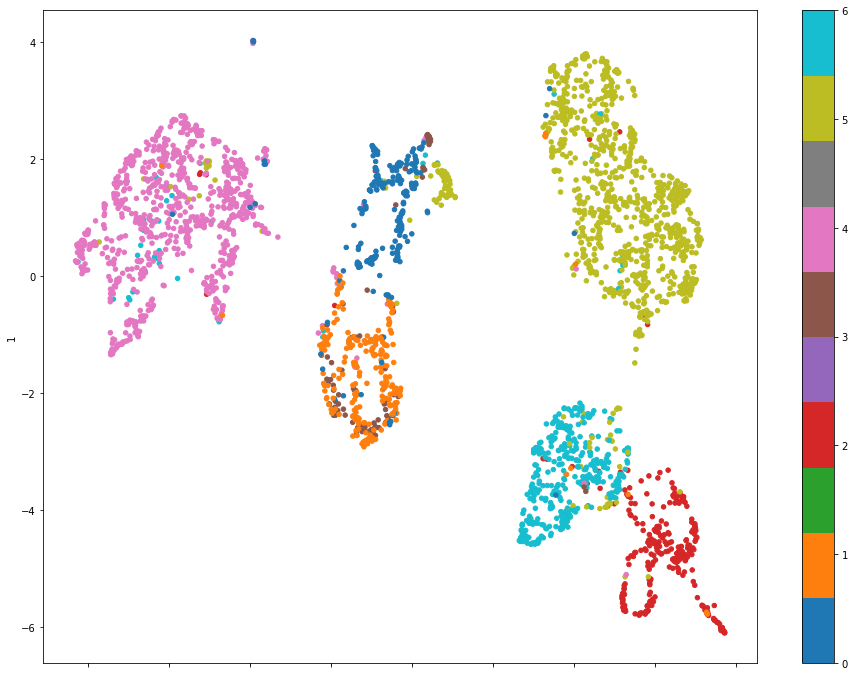

In [57]:
umap_df_l2.plot.scatter(x=0, y=1, c=zeisel_meta_df['level1class'].cat.codes, cmap=plt.cm.get_cmap('tab10'), figsize=(16,12))
plt.show()

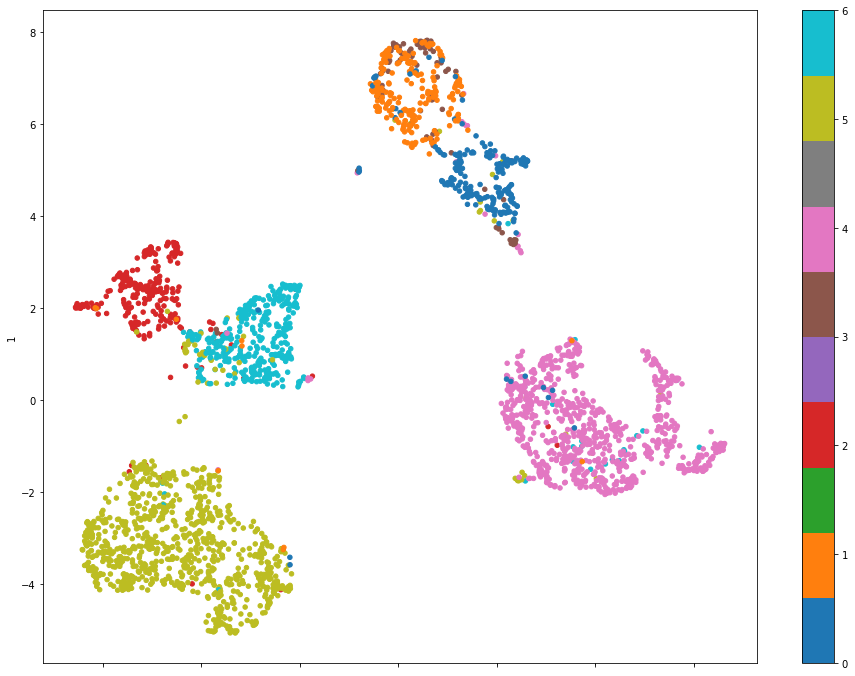

In [58]:
umap_df_l1.plot.scatter(x=0, y=1, c=zeisel_meta_df['level1class'].cat.codes, cmap=plt.cm.get_cmap('tab10'), figsize=(16,12))
plt.show()

---

In [85]:
snmf = ni.Snmf(zeisel_m, seed="nndsvd", rank=14, max_iter=20)

In [86]:
%%time

fit = snmf()
fig, ax = plt.subplots(1,1, figsize=(16, 12))
(fit.basis(), fit.coef())

CPU times: user 6min 51s, sys: 11min 54s, total: 18min 46s
Wall time: 1min 40s


In [87]:
fit.fit.sparseness()

(0.87938265832417273, 0.7511992236378765)

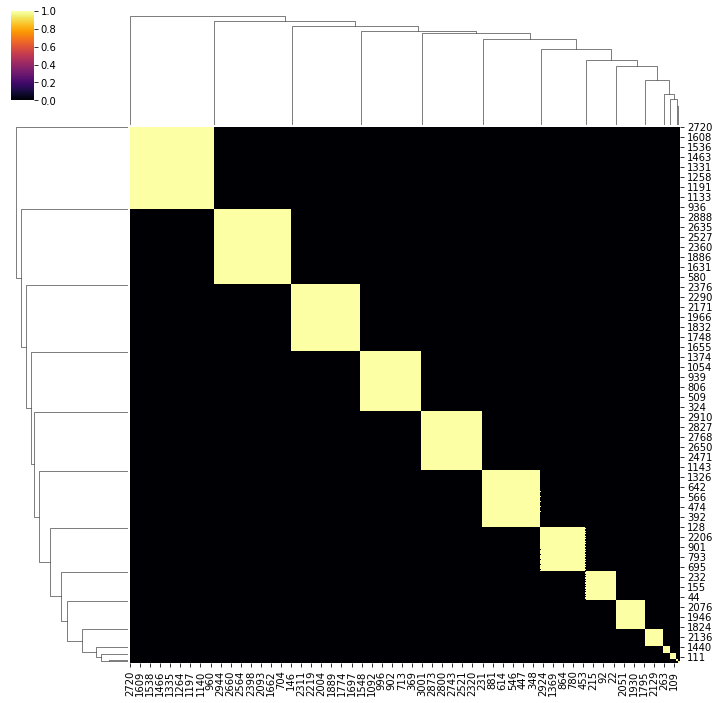

In [93]:
cnxn = fit.fit.connectivity()

sns.clustermap(cnxn, metric='euclidean', cmap='inferno', figsize=(12, 12))

plt.show()

In [89]:
sparse_w = fit.basis()
sparse_h = fit.coef()

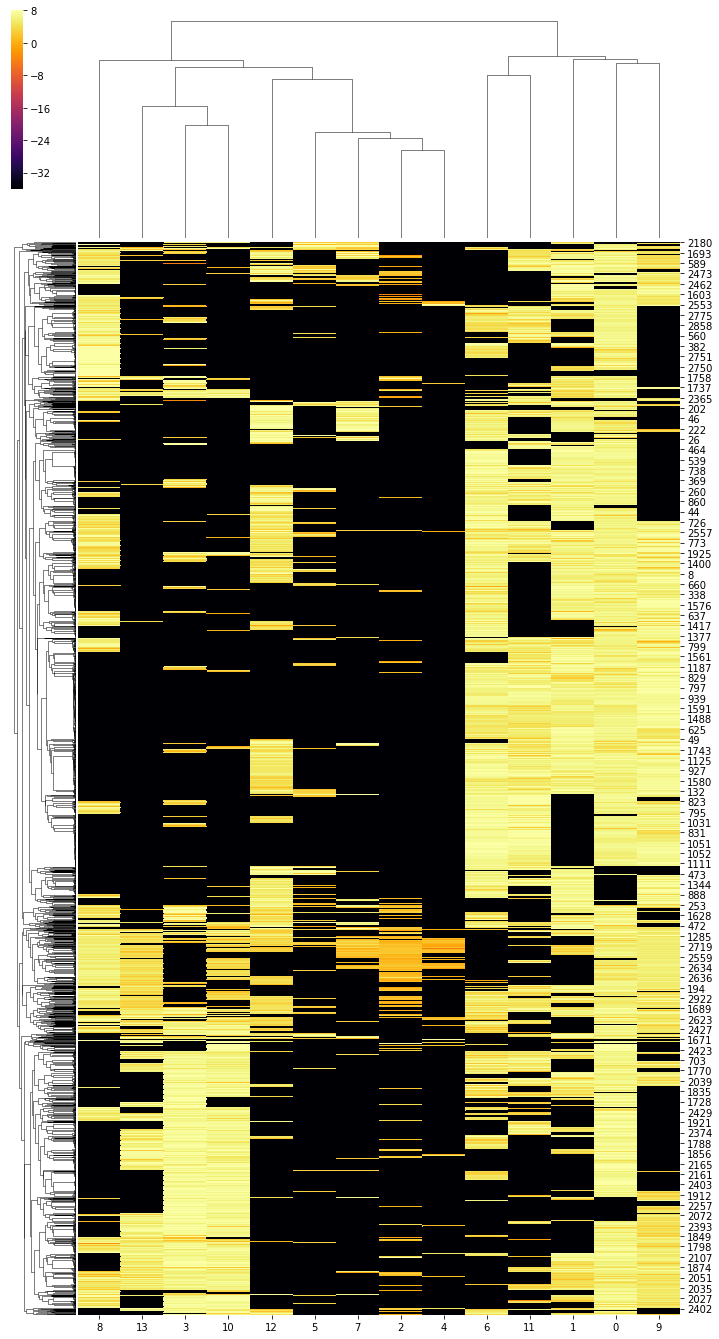

In [90]:
sns.clustermap(ma.filled(np.log(ma.masked_equal(sparse_h, 0)).T, 0), 
               cmap='inferno',               
               robust=True, 
               figsize=(12, 24))
plt.show()

In [94]:
nimfa_umap_df = pd.DataFrame(UMAP(random_state=666).fit_transform(sparse_h.T))

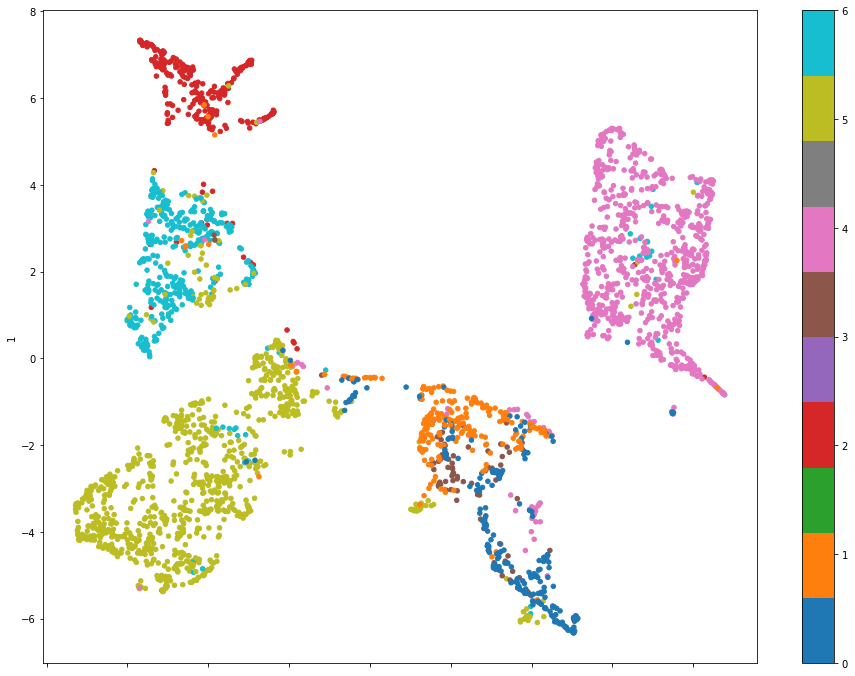

In [95]:
nimfa_umap_df.plot.scatter(x=0, y=1, c=zeisel_meta_df['level1class'].cat.codes, cmap=plt.cm.get_cmap('tab10'), figsize=(16,12))
plt.show()

In [27]:
%%time
model3 = NMF(n_components=20,
             solver='mu',
             init='nndsvda', 
             random_state=42, 
             verbose=False)

model3, W3, H3 = fit_nmf(zeisel_m, model3)

CPU times: user 1min 33s, sys: 1min 23s, total: 2min 56s
Wall time: 1min 1s


In [28]:
model3.reconstruction_err_

11435.959470033404

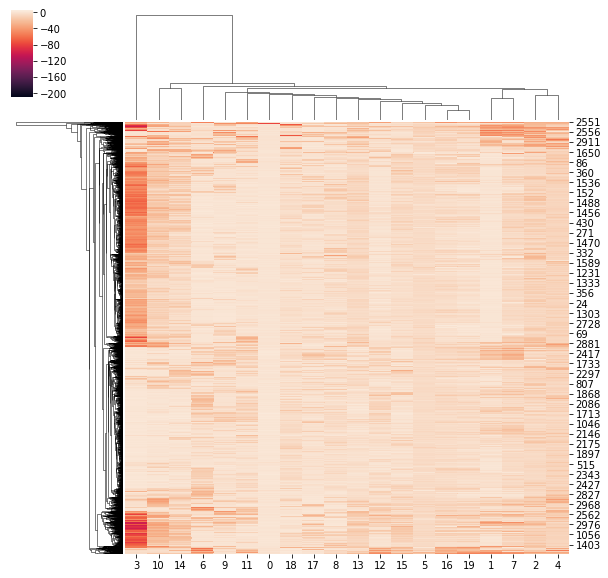

In [29]:
sns.clustermap(ma.filled(np.log(ma.masked_equal(H3, 0)).T, 0))
plt.show()

In [ ]:
%%time
tsne_df_3 = pd.DataFrame(TSNE(random_state=666, metric='manhattan').fit_transform(H3.T))

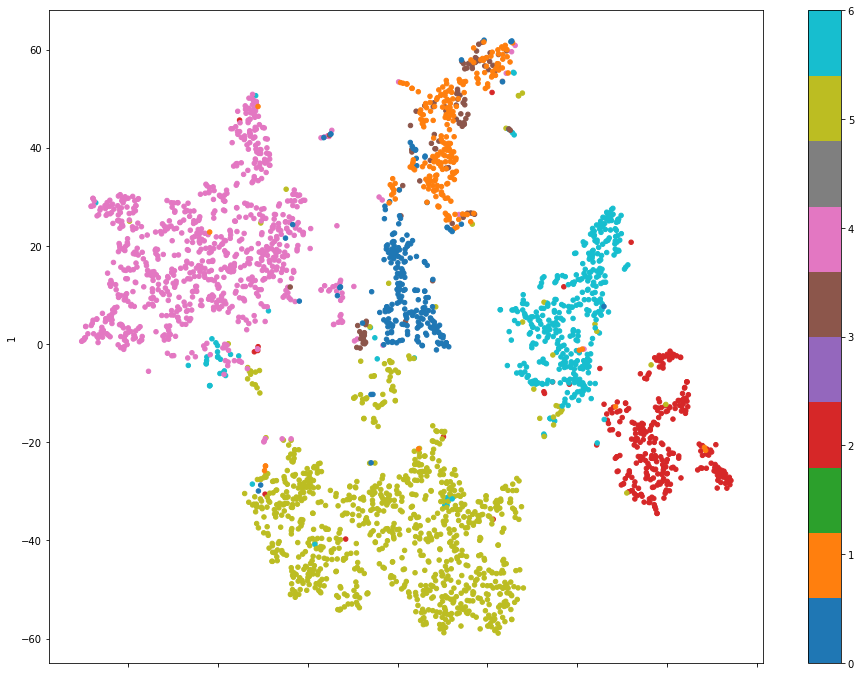

In [33]:
tsne_df_3.plot.scatter(x=0, y=1, c=zeisel_meta_df['level1class'].cat.codes, cmap=plt.cm.get_cmap('tab10'), figsize=(16,12))
plt.show()